## COVID-19 Chest CT Classifier Using PyTorch

In this notebook we will be implementing a COVID-19 chest CT classifier using PyTorch. Let us first begin by importing various things that we need. 

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from skimage.util import montage
import os
import cv2 as cv2
import random
import matplotlib.pyplot as plt 
import torch.optim as optim
from PIL import Image
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from torch.utils.tensorboard import SummaryWriter
import glob
import shutil
import numpy as np
from torchvision.models import vgg19_bn
import numpy as np
import seaborn as sns




random.seed(0)

log_dir = "~/logs"
writer = SummaryWriter(log_dir)
device = "cuda:0" if torch.cuda.is_available() else "cpu"


### Creating the Dataset
We will be using the CoViD-19 CT scans provided by UC San Diego [Github](https://github.com/UCSD-AI4H/COVID-CT). The dataset contains images taken from various radiology journals such as medRxiv, bioRxiv, NEJM, JAMA, Lancet

In [ ]:
!git clone https://github.com/UCSD-AI4H/COVID-CT

fatal: destination path 'COVID-CT' already exists and is not an empty directory.


We begin by extracting the images from the zipped files. 

In [ ]:
%cd COVID-CT/Images-processed/
!unzip CT_COVID.zip 
!unzip CT_NonCOVID.zip
!ls

/notebooks/COVID-CT/Images-processed
Archive:  CT_COVID.zip
replace CT_COVID/2020.03.01.20029769-p21-73_1%1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  CT_NonCOVID.zip
replace CT_NonCOVID/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
CT_COVID  CT_COVID.zip	CT_NonCOVID  CT_NonCOVID.zip  __MACOSX


In [ ]:
cd ..

/notebooks/COVID-CT


The CoViD-19 images are placed in the folder `CT_COVID` whereas the negative images are stored in the folder `CT_NonCOVID`. 

Before, we start to build our classifier, let me make a note about the structure of the data. We have `positive` class where we have scans of CoViD-19 patients whereas the negative class contains a mixture of healthy patients, and patients suffering with other non-CoViD-19 patients. 

In order to train a robust classifier, we must have the information about the non-CoViD-19 patients as well. This is important since doctors never send a person straight to get a CT scan. Infact, since pneumonia is a clinical diagnosis, people who are put under CT Scan will probably be suffrering from one of the respiratory illnesses such as viral / bacterial pneumonia / streps etc. 

Therefore, a practical classifier would have to differentiate between, say, CoViD-19 induced pneumonia and other types of pneumonia. However, the negative class in this dataset is mixed up and contains healthy lungs, as well as lungs of patients suffering from cancer as well. So what's the point of me saying this? That take this classifier as one for educational purposes, but any classifier you want to put out in the wild would require more differentiated data. 

With that in mind, let's visualise the some examples from our dataset. 

### Visualising Examples

We first begin with the covid positive cases.

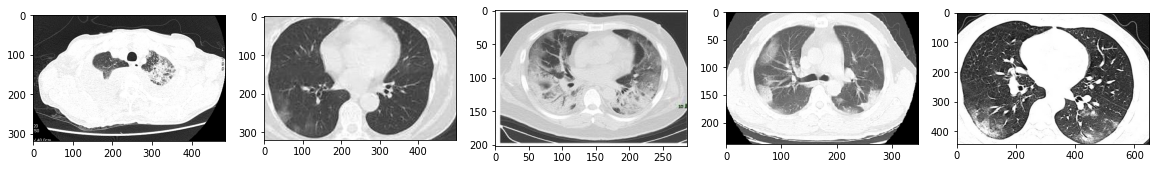

In [ ]:
covid_files_path = 'Images-processed/CT_COVID/'
covid_files      = [os.path.join(covid_files_path, x) for x in os.listdir(covid_files_path)]
covid_images    =  [cv2.imread(x) for x in random.sample(covid_files, 5)]

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(covid_images):
    plt.subplot(len(covid_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

And now, the negative cases.

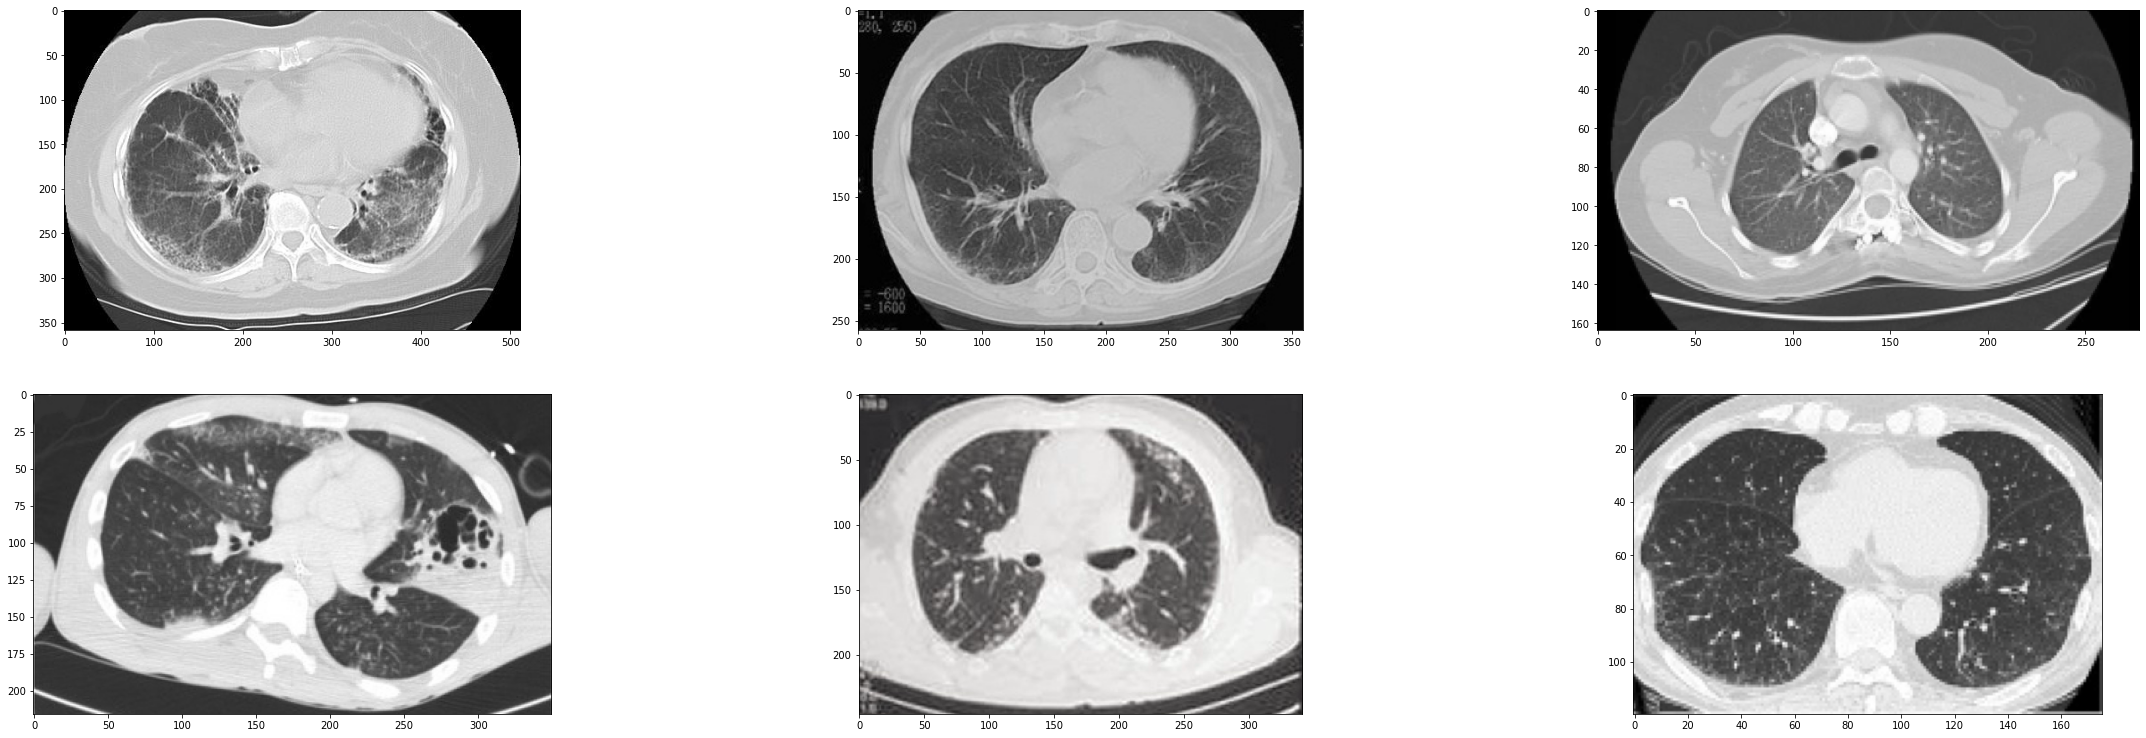

In [ ]:
non_covid_files_path = 'Images-processed/CT_NonCOVID/'
non_covid_files      = [os.path.join(non_covid_files_path, x) for x in os.listdir(non_covid_files_path)]
non_covid_images    =  [cv2.imread(x) for x in random.sample(non_covid_files, 6)]

plt.figure(figsize=(40,20))
columns = 3
for i, image in enumerate(non_covid_images):
    plt.subplot(len(non_covid_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

### Creating the Dataloader

We create the dataloader. It uses split information provided in the `Data-split` folder to split the data into training (425 examples), validation (118 examples) and test (203 examples) sets. 

In [ ]:
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, classes, covid_files, non_covid_files, transform=None):
        self.root_dir = root_dir
        self.classes = classes
        self.files_path = [non_covid_files, covid_files]
        self.image_list = []

        # read the files from data split text files
        covid_files = read_txt(covid_files)
        non_covid_files = read_txt(non_covid_files)

        # combine the positive and negative files into a cummulative files list
        for cls_index in range(len(self.classes)):
            
            class_files = [[os.path.join(self.root_dir, self.classes[cls_index], x), cls_index] \
                            for x in read_txt(self.files_path[cls_index])]
            self.image_list += class_files
                
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        path = self.image_list[idx][0]
        
        # Read the image
        image = Image.open(path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)

        label = int(self.image_list[idx][1])

        data = {'img':   image,
                'label': label,
                'paths' : path}

        return data

We also define a helper function `read_txt` that will help us read the list of files from text files containing the train-valid-test splits in the folder `Data-split` 

In [ ]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

## Input Preprocessing and Data Augmentation

For training data, we

1. Resize the shorter side of the image to 256 while maintaining the aspect ratio
2. Do a random crop of size ranging from 50% to 100% of the dimensions of the image and aspect ratio ranging randomly from 75% to 133% of the original aspect ratio. Finally, the crop is resized to 224 x 224
3. Horizontally flip the image with a probability of 0.5 
4. Normalise the image to have 0 mean and standard deviation 1


For testing, we

1. Resize the image to 224 x 224. 
2. Normalise the image to have mean 0 and standard deviation 1


In [ ]:
normalize = transforms.Normalize(mean=[0,0,0], std=[1,1,1])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

With our `Dataset` and `DataLoader` classes defined, let us now instantiate them. We use the label `0` for the non-Covid cases whereas we use `1` for the Covid positive cases

In [ ]:
batchsize = 8

trainset = CovidCTDataset(root_dir='Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/trainCT_COVID.txt',
                          non_covid_files='Data-split/NonCOVID/trainCT_NonCOVID.txt',
                          transform= train_transformer)
valset = CovidCTDataset(root_dir='Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/valCT_COVID.txt',
                          non_covid_files = 'Data-split/NonCOVID/valCT_NonCOVID.txt',
                          transform= val_transformer)
testset = CovidCTDataset(root_dir='Images-processed/',
                          classes = ['CT_NonCOVID', 'CT_COVID'],
                          covid_files='Data-split/COVID/testCT_COVID.txt',
                          non_covid_files='Data-split/NonCOVID/testCT_NonCOVID.txt',
                          transform= val_transformer)

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

## Defining Metrics

We will now define a function called `compute_metrics`. This function will compute the following quantities over a dataset, 

1. Accuracy
2. Sensitivity
3. Specificity
4. Area under ROC Curve
5. Average Loss

and some other quantities that will  help us visualise things later

In [ ]:
def compute_metrics(model, test_loader, plot_roc_curve = False):
    
    model.eval()
    
    val_loss = 0
    val_correct = 0
    
    criterion = nn.CrossEntropyLoss()
    
    score_list   = torch.Tensor([]).to(device)
    pred_list    = torch.Tensor([]).to(device).long()
    target_list  = torch.Tensor([]).to(device).long()
    path_list    = []

    
    for iter_num, data in enumerate(test_loader):
        
        # Convert image data into single channel data
        image, target = data['img'].to(device), data['label'].to(device)
        paths = data['paths']
        path_list.extend(paths)
        
        # Compute the loss
        with torch.no_grad():
            output = model(image)
        
        # Log loss
        val_loss += criterion(output, target.long()).item()

        
        # Calculate the number of correctly classified examples
        pred = output.argmax(dim=1, keepdim=True)
        val_correct += pred.eq(target.long().view_as(pred)).sum().item()
        
        # Bookkeeping 
        score_list   = torch.cat([score_list, nn.Softmax(dim = 1)(output)[:,1].squeeze()])
        pred_list    = torch.cat([pred_list, pred.squeeze()])
        target_list  = torch.cat([target_list, target.squeeze()])
        
    
    classification_metrics = classification_report(target_list.tolist(), pred_list.tolist(),
                                                  target_names = ['CT_NonCOVID', 'CT_COVID'],
                                                  output_dict= True)
    
    
    # sensitivity is the recall of the positive class
    sensitivity = classification_metrics['CT_COVID']['recall']
    
    # specificity is the recall of the negative class 
    specificity = classification_metrics['CT_NonCOVID']['recall']
    
    # accuracy
    accuracy = classification_metrics['accuracy']
    
    # confusion matrix
    conf_matrix = confusion_matrix(target_list.tolist(), pred_list.tolist())
    
    # roc score
    roc_score = roc_auc_score(target_list.tolist(), score_list.tolist())
    
    # plot the roc curve
    if plot_roc_curve:
        fpr, tpr, _ = roc_curve(target_list.tolist(), score_list.tolist())
        plt.plot(fpr, tpr, label = "Area under ROC = {:.4f}".format(roc_score))
        plt.legend(loc = 'best')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    
    # put together values
    metrics_dict = {"Accuracy": accuracy,
                    "Sensitivity": sensitivity,
                    "Specificity": specificity,
                    "Roc_score"  : roc_score, 
                    "Confusion Matrix": conf_matrix,
                    "Validation Loss": val_loss / len(test_loader),
                    "score_list":  score_list.tolist(),
                    "pred_list": pred_list.tolist(),
                    "target_list": target_list.tolist(),
                    "paths": path_list}
    
    
    return metrics_dict

## Define the Model

We now define out model. We use the pretrained VGG-19 with batch normalisation as our model. We then replace it's final linear layer with one having 2 neurons at it's output.

We use cross entropy loss as our objective function. 

In [ ]:
model = vgg19_bn(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Training Hyperparameters

We now set the training hyperparameters. We use a initial learning rate of 0.01. We used Stochastic Gradient descent with momentum value of 0.9. 

In [ ]:
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)


### Early Stopping

We implement a class called `EarlyStopping` which keeps the running averages of both loss and accuracy. This will help us in implementing, well, you guessed it, early stopping.  

This class keeps a moving average of the loss and accuracy. If the metric doesn't improve beyond a set number of epochs, defined by the `patience`, then the method `stop` returns:

**0**, if patience has not been exhausted for either accuracy or the loss 

**1**, if patience is exhausted for both the accuracy and the loss

**2**, if patience has been exhausted only for accuracy

**3**, if patience has been exhausted only for loss

Not that the usage of term "patience has been exhausted" for a metric means that the metric has not been improving for set number of epochs.


In [ ]:
from collections import deque

class EarlyStopping(object):
    def __init__(self, patience = 8):
        super(EarlyStopping, self).__init__()
        self.patience = patience
        self.previous_loss = int(1e8)
        self.previous_accuracy = 0
        self.init = False
        self.accuracy_decrease_iters = 0
        self.loss_increase_iters = 0
        self.best_running_accuracy = 0
        self.best_running_loss = int(1e7)
    
    def add_data(self, model, loss, accuracy):
        
        # compute moving average
        if not self.init:
            running_loss = loss
            running_accuracy = accuracy 
            self.init = True
        
        else:
            running_loss = 0.2 * loss + 0.8 * self.previous_loss
            running_accuracy = 0.2 * accuracy + 0.8 * self.previous_accuracy
        
        # check if running accuracy has improved beyond the best running accuracy recorded so far
        if running_accuracy < self.best_running_accuracy:
            self.accuracy_decrease_iters += 1
        else:
            self.best_running_accuracy = running_accuracy
            self.accuracy_decrease_iters = 0
        
        # check if the running loss has decreased from the best running loss recorded so far
        if running_loss > self.best_running_loss:
            self.loss_increase_iters += 1
        else:
            self.best_running_loss = running_loss
            self.loss_increase_iters = 0
        
        # log the current accuracy and loss
        self.previous_accuracy = running_accuracy
        self.previous_loss = running_loss        
        
    
    def stop(self):
        
        # compute thresholds
        accuracy_threshold = self.accuracy_decrease_iters > self.patience
        loss_threshold = self.loss_increase_iters > self.patience
        
        
        # return codes corresponding to exhuaustion of patience for either accuracy or loss 
        # or both of them
        if accuracy_threshold and loss_threshold:
            return 1
        
        if accuracy_threshold:
            return 2
        
        if loss_threshold:
            return 3
        
        
        return 0
    
    def reset(self):
        # reset
        self.accuracy_decrease_iters = 0
        self.loss_increase_iters = 0
    
early_stopper = EarlyStopping(patience = 5)

## Training Loop

If the patience for running validation loss is exhuasted but not for running accuracy, we multiply our learning rate 0.1. 

If patience for both running validation loss and running accuracy is exhausted, we stop the training. The reasons for such a policy lies in the nature of the cross entropy loss where a higher validation loss may not necessarily correspond to a lower accuracy. 

We train for a maximum of 60 epochs. 

We use a batch size of 64. Since my machine couldn't accommodate such a batch size, I have used a batch size of 8, and accumulated gradient over 8 iterations to effectively perform a batch size 64 update.

In [ ]:
best_model = model
best_val_score = 0

criterion = nn.CrossEntropyLoss()

for epoch in range(60):

    model.train()    
    train_loss = 0
    train_correct = 0
    
    for iter_num, data in enumerate(train_loader):
        image, target = data['img'].to(device), data['label'].to(device)     

        # Compute the loss
        output = model(image)
        loss = criterion(output, target.long()) / 8
        
        # Log loss
        train_loss += loss.item()
        loss.backward()

        # Perform gradient udpate
        if iter_num % 8 == 0:
            optimizer.step()
            optimizer.zero_grad()
            

        # Calculate the number of correctly classified examples
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
        
    
    # Compute and print the performance metrics
    metrics_dict = compute_metrics(model, val_loader)
    print('------------------ Epoch {} Iteration {}--------------------------------------'.format(epoch,
                                                                                                 iter_num))
    print("Accuracy \t {:.3f}".format(metrics_dict['Accuracy']))
    print("Sensitivity \t {:.3f}".format(metrics_dict['Sensitivity']))
    print("Specificity \t {:.3f}".format(metrics_dict['Specificity']))
    print("Area Under ROC \t {:.3f}".format(metrics_dict['Roc_score']))
    print("Val Loss \t {}".format(metrics_dict["Validation Loss"]))
    print("------------------------------------------------------------------------------")
    
    # Save the model with best validation accuracy
    if metrics_dict['Accuracy'] > best_val_score:
        torch.save(model, "/storage/best_model.pkl")
        best_val_score = metrics_dict['Accuracy']
    
    
    # print the metrics for training data for the epoch
    print('\nTraining Performance Epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    
    # log the accuracy and losses in tensorboard
    writer.add_scalars( "Losses", {'Train loss': train_loss / len(train_loader), 'Validation_loss': metrics_dict["Validation Loss"]},
                                   epoch)
    writer.add_scalars( "Accuracies", {"Train Accuracy": 100.0 * train_correct / len(train_loader.dataset),
                                       "Valid Accuracy": 100.0 * metrics_dict["Accuracy"]}, epoch)

    # Add data to the EarlyStopper object
    early_stopper.add_data(model, metrics_dict['Validation Loss'], metrics_dict['Accuracy'])
    
    # If both accuracy and loss are not improving, stop the training
    if early_stopper.stop() == 1:
        break
    
    # if only loss is not improving, lower the learning rate
    if early_stopper.stop() == 3:
        for param_group in optimizer.param_groups:
            learning_rate *= 0.1
            param_group['lr'] = learning_rate
            print('Updating the learning rate to {}'.format(learning_rate))
            early_stopper.reset()
    
    

------------------ Epoch 0 Iteration 53--------------------------------------
Accuracy 	 0.669
Sensitivity 	 0.650
Specificity 	 0.690
Area Under ROC 	 0.736
Val Loss 	 0.6907568365335465
------------------------------------------------------------------------------

Training Performance Epoch 0: Average loss: 0.0075, Accuracy: 327/425 (77%)

------------------ Epoch 1 Iteration 53--------------------------------------
Accuracy 	 0.720
Sensitivity 	 0.583
Specificity 	 0.862
Area Under ROC 	 0.821
Val Loss 	 0.7932620000365811
------------------------------------------------------------------------------

Training Performance Epoch 1: Average loss: 0.0049, Accuracy: 377/425 (89%)

------------------ Epoch 2 Iteration 53--------------------------------------
Accuracy 	 0.780
Sensitivity 	 0.867
Specificity 	 0.690
Area Under ROC 	 0.852
Val Loss 	 0.6248456401129564
------------------------------------------------------------------------------

Training Performance Epoch 2: Average loss

------------------ Epoch 24 Iteration 53--------------------------------------
Accuracy 	 0.788
Sensitivity 	 0.850
Specificity 	 0.724
Area Under ROC 	 0.873
Val Loss 	 0.8105445455759763
------------------------------------------------------------------------------

Training Performance Epoch 24: Average loss: 0.0008, Accuracy: 418/425 (98%)

------------------ Epoch 25 Iteration 53--------------------------------------
Accuracy 	 0.763
Sensitivity 	 0.683
Specificity 	 0.845
Area Under ROC 	 0.878
Val Loss 	 0.8666094580083155
------------------------------------------------------------------------------

Training Performance Epoch 25: Average loss: 0.0009, Accuracy: 417/425 (98%)

------------------ Epoch 26 Iteration 53--------------------------------------
Accuracy 	 0.788
Sensitivity 	 0.850
Specificity 	 0.724
Area Under ROC 	 0.875
Val Loss 	 0.8203572131538143
------------------------------------------------------------------------------

Training Performance Epoch 26: Averag

## Test Performance

Now, we guage our model's performance on the test dataset. You could use the latest model or one with best validation accuracy.



In [ ]:
# model = torch.load("/storage/best_model.pkl")
model = torch.load("/storage/pretrained_covid_model.pkl" )

metrics_dict = compute_metrics(model, test_loader, plot_roc_curve = True)
print('------------------- Test Performance --------------------------------------')
print("Accuracy \t {:.3f}".format(metrics_dict['Accuracy']))
print("Sensitivity \t {:.3f}".format(metrics_dict['Sensitivity']))
print("Specificity \t {:.3f}".format(metrics_dict['Specificity']))
print("Area Under ROC \t {:.3f}".format(metrics_dict['Roc_score']))
print("------------------------------------------------------------------------------")

NameError: name 'torch' is not defined

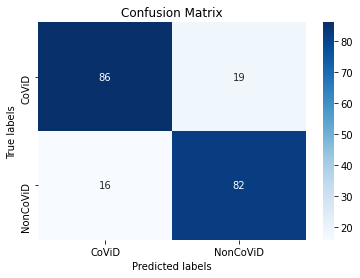

In [ ]:
conf_matrix = metrics_dict["Confusion Matrix"]
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap = 'Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['CoViD', 'NonCoViD']); ax.yaxis.set_ticklabels(['CoViD', 'NonCoViD']);

### Identifying Mistakes

We now look at the the mistakes that our model has committed. We first get the indices of the misclassified examples. Then we look at the scores assigned to the misclassified examples and plot a histogram.

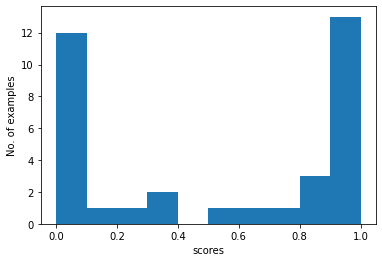

In [ ]:
targets = np.array(metrics_dict['target_list'])
preds   = np.array(metrics_dict['pred_list'])
scores  = np.array(metrics_dict['score_list'])


misclassified_indexes = np.nonzero(targets != preds)
misclassified_scores = scores[misclassified_indexes[0]]

# plot the historgram of misclassified scores
plt.hist(misclassified_scores)
plt.xlabel("scores")
plt.ylabel("No. of examples")
plt.show()

We plot the scores to see the nature of mistakes our model commits. Misclassification of examples with scores near to 0.5 (threshold) is all right. These represented examples on which the model suffers from ambiguity, and could be classified as hard examples.

However, we see spikes at a both the ends 0.0 and 1.0. This means that the model is very confident in misclassifying these examples

## Using Grad-CAM to visualise activations

Gradient-weighted Class Activation Mapping, or more simply, Grad-CAM helps us get *what the network is seeing*, and helps us see which neurons are firing in a particular layer given the image as input. 

We first begin by cloning the requisite repo implementing Grad-CAM. 

In [ ]:
!git clone https://github.com/jacobgil/pytorch-grad-cam
!mv pytorch-grad-cam gradcam

Cloning into 'pytorch-grad-cam'...
remote: Enumerating objects: 122, done.
remote: Total 122 (delta 0), reused 0 (delta 0), pack-reused 122
Receiving objects: 100% (122/122), 258.23 KiB | 11.74 MiB/s, done.
Resolving deltas: 100% (49/49), done.


Now, we define a function called `do_grad_cam` which takes the path of an image and outputs an image with the grad-cam mask.

In [ ]:
from gradcam.gradcam import *

def do_grad_cam(path):

    # Initialise the grad cam object. 
    # we use model.features as the feature extractor and use the layer no. 35 for gradients. 
    grad_cam = GradCam(model=model, feature_module=model.features, \
                           target_layer_names=["35"], use_cuda=True)

    # read in the image, and prepare it for the network
    orig_im = cv2.imread(path)
    img = Image.fromarray(orig_im)
    inp = val_transformer(img).unsqueeze(0)

    # main inference
    mask = grad_cam(inp, None)

    # create the heatmap 
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    
    #add the heatmap to the original image
    cam = heatmap + np.float32(cv2.resize(orig_im, (224,224))/255.)
    cam = cam / np.max(cam)
    
    # BGR -> RGB since OpenCV operates with BGR values. 
    cam = cam[:,:,::-1] 
    
    return cam


Let us now use the grad cam functionality to visualise a few examples from True positives, True negatives, False positives and false negatives.  

### True Positives

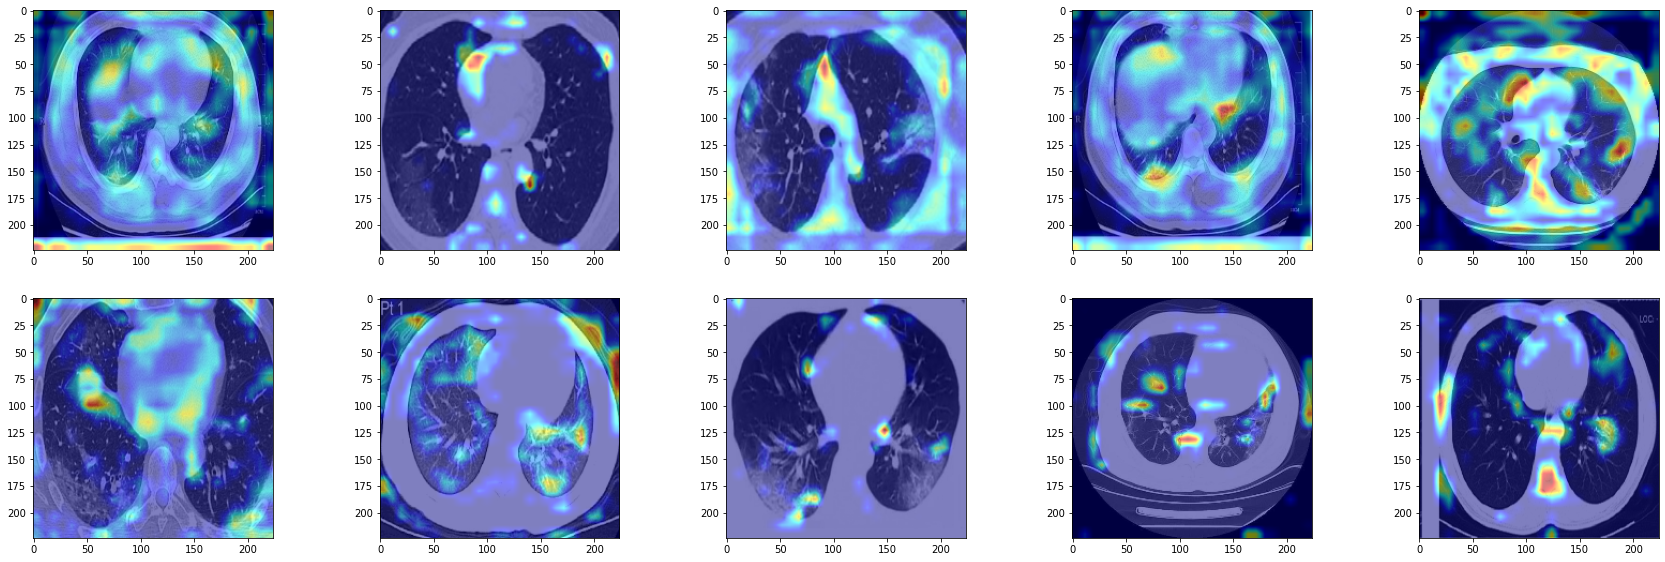

In [ ]:
true_positives = np.logical_and(preds == 1, targets == 1)
true_positives = np.logical_and(true_positives, scores > 0.9)
true_positives_indices = np.nonzero(true_positives)
true_positives_paths = [metrics_dict['paths'][i] for i in true_positives_indices[0]]


true_positive_images    =  [do_grad_cam(x) for x in random.sample(true_positives_paths, 10)]

plt.figure(figsize=(30,15))
columns = 5
for i, image in enumerate(true_positive_images):
    plt.subplot(len(true_positive_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

### False Positives 

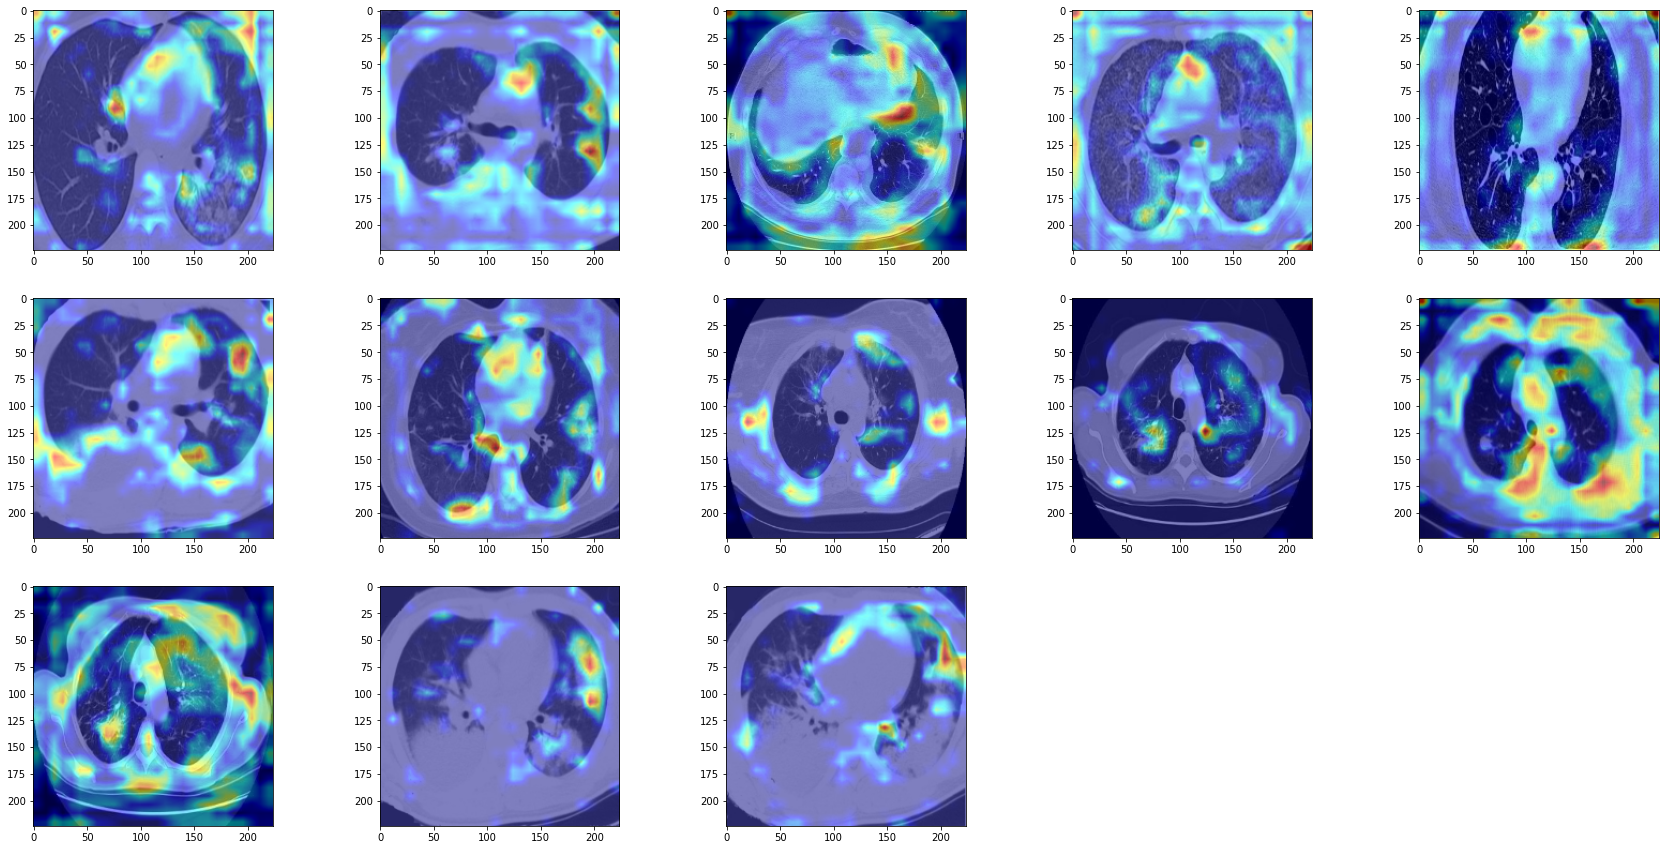

In [ ]:
false_positives = np.logical_and(preds == 1, targets == 0)
false_positives = np.logical_and(false_positives, scores > 0.9)
false_positive_indices = np.nonzero(false_positives)
false_positive_paths = [metrics_dict['paths'][i] for i in false_positive_indices[0]]

false_pos_images    =  [do_grad_cam(x) for x in random.sample(false_positive_paths, len(false_positive_paths))]

plt.figure(figsize=(30,15))
columns = 5
for i, image in enumerate(false_pos_images):
    plt.subplot(len(false_pos_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

### True Negatives

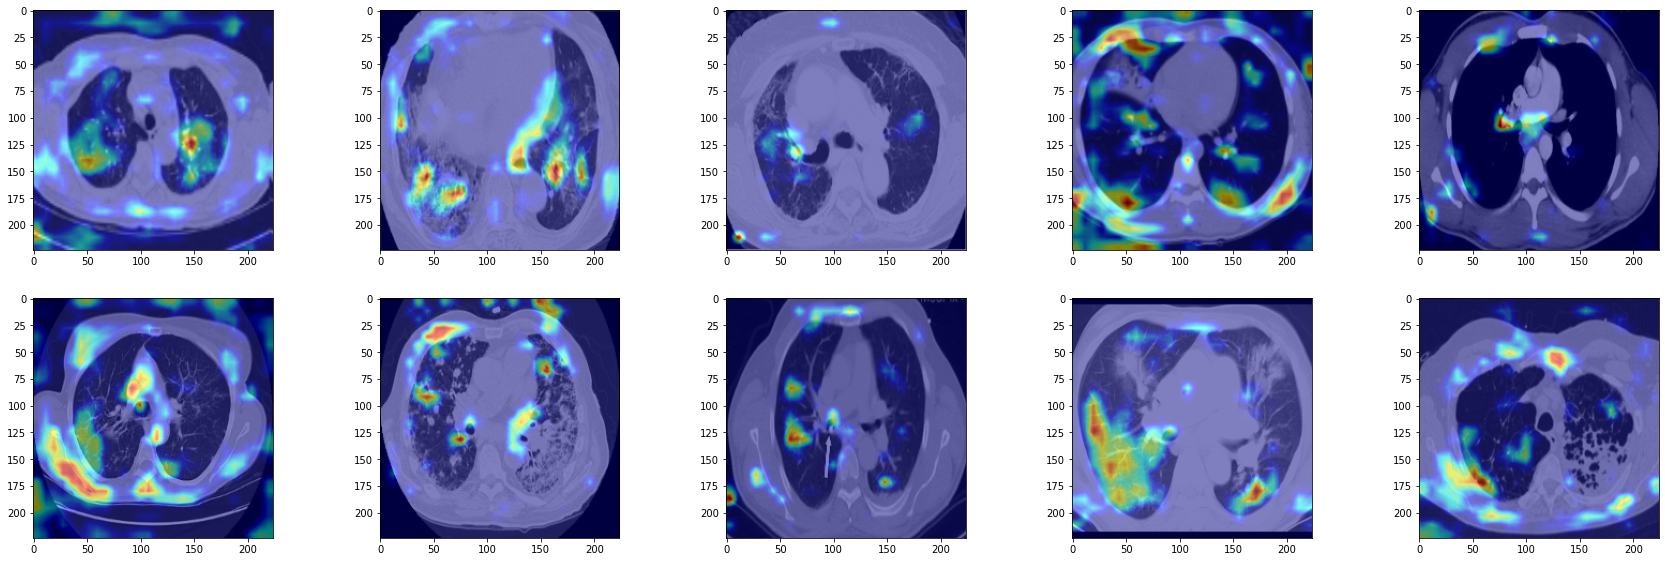

In [ ]:
true_negatives = np.logical_and(preds == 0, targets == 0)
# true_negatives = np.logical_and(true_negatives, scores)
true_negatives_indices = np.nonzero(true_negatives)
true_negatives_paths = [metrics_dict['paths'][i] for i in true_negatives_indices[0]]


true_negative_images    =  [do_grad_cam(x) for x in random.sample(true_negatives_paths, 10)]

plt.figure(figsize=(30,15))
columns = 5
for i, image in enumerate(true_negative_images):
    plt.subplot(len(true_negative_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

### False Negatives

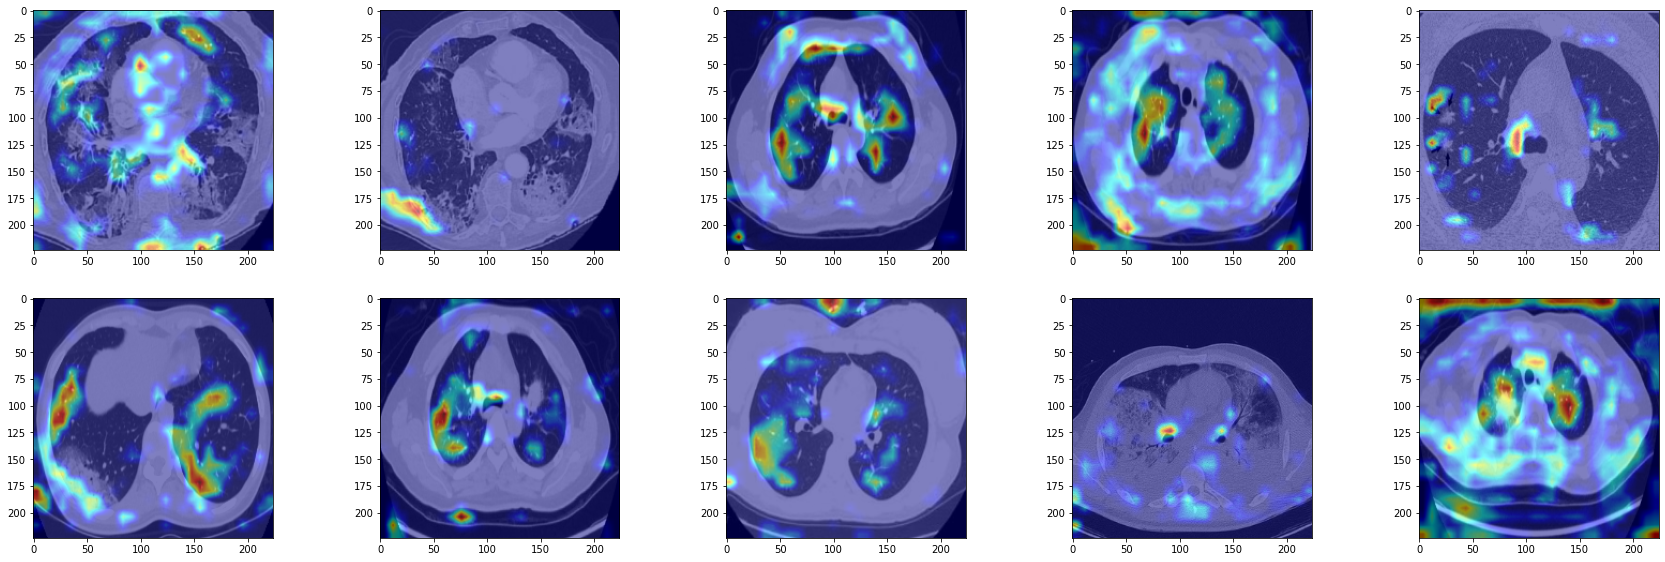

In [ ]:
false_negatives = np.logical_and(preds == 0, targets == 1)
false_negatives = np.logical_and(false_negatives, scores < 0.1)
false_negatives_indices = np.nonzero(false_negatives)
false_negatives_paths = [metrics_dict['paths'][i] for i in false_negatives_indices[0]]


false_neg_images    =  [do_grad_cam(x) for x in random.sample(false_negatives_paths, 10)]

plt.figure(figsize=(30,15))
columns = 5
for i, image in enumerate(false_neg_images):
    plt.subplot(len(false_neg_images) / columns + 1, columns, i + 1)
    plt.imshow(image)